In [82]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from glob import glob
import PIL
from PIL import Image
import time
from tqdm import tqdm
import os
import transformers
from transformers import AutoProcessor
from transformers import AutoModelForCausalLM
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import warnings
warnings.filterwarnings(action='ignore')
import torchtext
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer

OSError: [WinError 127] The specified procedure could not be found

In [47]:
image_path = "C:/Users/Abhiram P/Desktop/Project1/all_data/train/radiology/images/"
images = glob(image_path + "*.jpg")
len(images)

65420

In [12]:
train_df = pd.read_csv(r"C:\Users\Abhiram P\Desktop\Project1\all_data\train\radiologytraindata.csv")

In [13]:
train_df.head()

,id,name,caption
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...


In [20]:
filter_train_mask =  train_df['caption'].str.contains('chest x-ray', case=False)
filter_train_df = train_df[filter_train_mask]
filter_train_df.head()

,id,name,caption
69,ROCO_00087,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ..."
141,ROCO_00172,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...
180,ROCO_00232,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ..."
215,ROCO_00274,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n
307,ROCO_00383,PMC5018069_gr1.jpg,Chest X-ray on the day of admission showing d...


In [30]:
filter_train_df['images'] = image_path + filter_train_df['name']
filter_train_df.head()

,id,name,caption,images
69,ROCO_00087,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ...",C:/Users/Abhiram P/Desktop/Project1/all_data/t...
141,ROCO_00172,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...,C:/Users/Abhiram P/Desktop/Project1/all_data/t...
180,ROCO_00232,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ...",C:/Users/Abhiram P/Desktop/Project1/all_data/t...
215,ROCO_00274,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n,C:/Users/Abhiram P/Desktop/Project1/all_data/t...
307,ROCO_00383,PMC5018069_gr1.jpg,Chest X-ray on the day of admission showing d...,C:/Users/Abhiram P/Desktop/Project1/all_data/t...


In [36]:
captions = filter_train_df.apply(lambda row: {"file_name": row["name"], "text": row["caption"]}, axis=1).tolist()

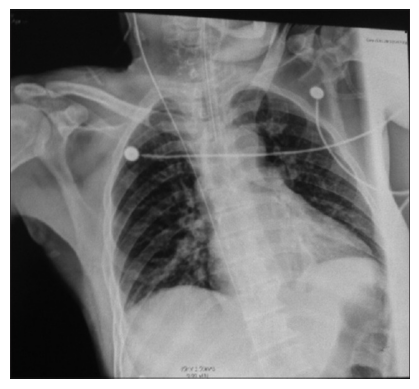

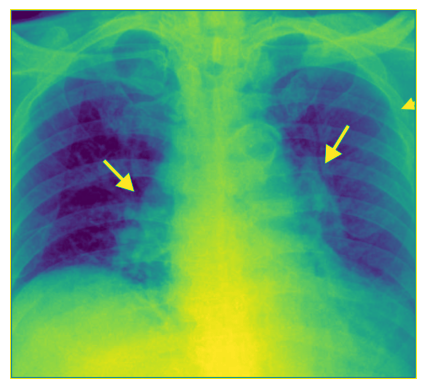

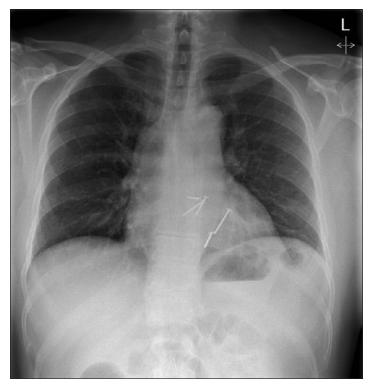

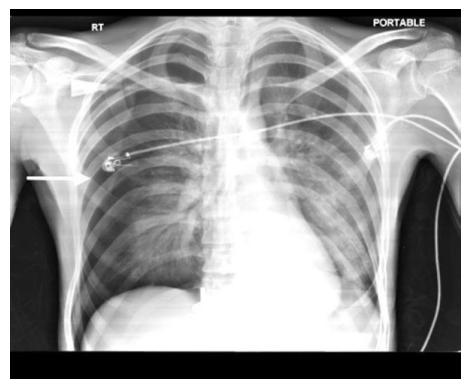

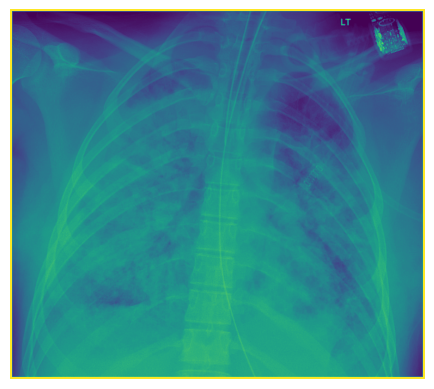

In [53]:
filtered_train_images = filter_train_df['images'].tolist()

for img_path in filtered_train_images[:5]:  
    try:
        img = Image.open(img_path)
        plt.figure()
        plt.imshow(img)
        plt.axis('off')  
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

In [83]:
train_dataset = ImageCaptioningDataset(filter_train_df, processor)


In [84]:
tokenizer = get_tokenizer("basic_english")

def build_vocab(captions):
    vocab = torchtext.vocab.build_vocab_from_iterator(map(tokenizer, captions), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
    vocab.set_default_index(vocab["<unk>"])
    return vocab

NameError: name 'get_tokenizer' is not defined

In [85]:
vocab = build_vocab(filter_train_df['caption'])


NameError: name 'build_vocab' is not defined

In [86]:
def caption_to_tensor(caption, vocab):
    tokens = tokenizer(caption)
    token_ids = [vocab["<bos>"]] + [vocab[token] for token in tokens] + [vocab["<eos>"]]
    return torch.tensor(token_ids)

In [87]:
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, image_dir, vocab, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['name']
        caption = self.dataframe.iloc[idx]['caption']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption_tensor = caption_to_tensor(caption, self.vocab)

        return image, caption_tensor

In [88]:
for epoch in range(10):  
    model.train()
    running_loss = 0.0
    for images, captions in dataloader:
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
        captions = captions.to('cuda' if torch.cuda.is_available() else 'cpu')  

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, captions) 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/10], Loss: {running_loss/len(dataloader)}")


AttributeError: 'tuple' object has no attribute 'to'